In [50]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
%pip install pydicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
%pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
%pip install plotly
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [51]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")

print("Path to dataset files:", path)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Path to dataset files: /Users/ashleyxu/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/versions/1


In [71]:
import tarfile
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def extract_task1_files(root="./data"):
    tar = tarfile.open("data/BraTS2021_Training_Data.tar")
    tar.extractall("data/traning_data")
    tar.close()


In [72]:
extract_task1_files()

In [61]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
    
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{scan_type}.nii.gz'
        return self.read_file(scan_filename)

In [55]:
import plotly.graph_objects as go
import numpy as np


def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.2, scale:str='Teal',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader, mri_downsample:int=10, mri_colorscale:str='Ice'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale
    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        # only (1/mri_downsample) is sampled for the resulting image
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
    
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        # 1/1, 1/3 and 1/5 pixels for tumor tissue classes 1(core), 2(invaded) and 4(enhancing)
        sampling = {
            1: 1, 2: 3, 4: 5
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=class_idx/4
            )
        return tumors
    
    def collect_patient_data(self, scan:dict) -> tuple:
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(**clean_mri, scale=self.mri_colorscale, opacity=0.3, hover='skip', name='Brain MRI'),
            generate_3d_scatter(**tumors[1], opacity=0.8, hover='all', name='Necrotic tumor core'),
            generate_3d_scatter(**tumors[2], opacity=0.4, hover='all', name='Peritumoral invaded tissue'),
            generate_3d_scatter(**tumors[4], opacity=0.4, hover='all', name='GD-enhancing tumor'),
        ], markers_created
    
    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            title=f"[Patient id:{patient_idx}] brain MRI scan ({num_markers} points)",
            legend_title="Pixel class (click to enable/disable)",
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0,r=0,b=0,t=30
            ),
            legend=dict(itemsizing='constant')
        )
        return fig

In [78]:
reader = ImageReader('data/traning_data', img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=25)


/var/folders/5t/5kcb7x394tdf6wpn5rhw7h900000gn/T/ipykernel_18413/1794303141.py:15: UserWarning:

Argument 'value' is not valid and will be ignored.



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
flair    (155, 240, 240)
seg    (155, 240, 240)
[0 1 2 4]
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


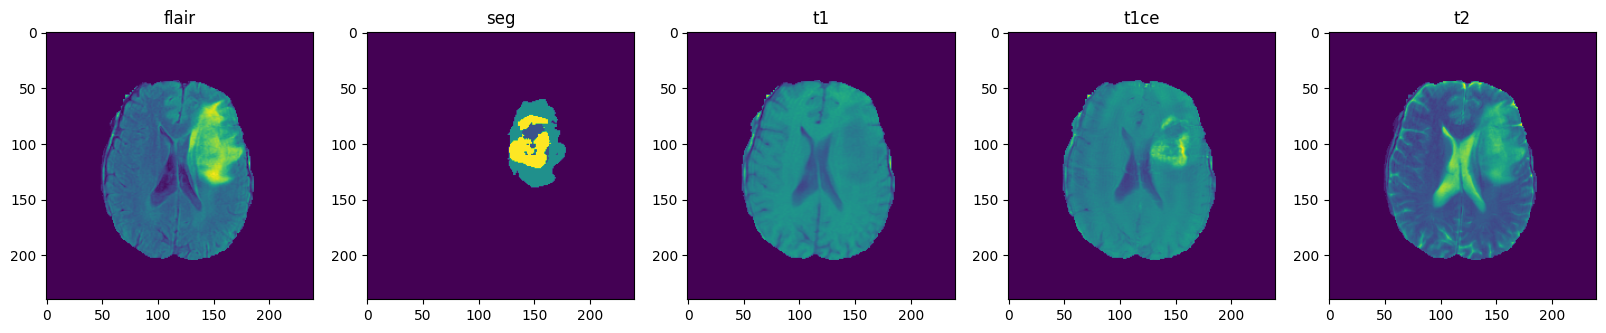

In [75]:

import tarfile
%pip install SimpleITK
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('data/traning_data/BraTS2021_01281/BraTS2021_01281_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])
    if name=='seg':
        print(np.unique(im))
    
    plt.subplot(1,5,i)
    plt.imshow(im)
    plt.title(name)

In [86]:
%pip install --upgrade nbformat
fig = viewer.get_3d_scan(9, 'flair')
plotly.offline.iplot(fig)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [76]:
%pip install scikit-image
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.4 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 315 kB 73.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                    'dtype': 'f8',
                    'shape': '128, 128'}},
             {'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: %{z}<extra></extra>',
              'name': '1',
              'type': 'heatmap',
              'xaxis': 'x2',
              'yaxis': 'y2',
              'z': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                    'dtype': 'f8',
                    'shape': '128, 128'}},
             {'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>color: %{z}<extra></extra>',
              'name': '2',
              'type': 'heatmap',
              'xaxis': 'x3',
              'yaxis': 'y3',
              'z': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAA='),
                    'dtype': 'f8',
                    'shape': '128, 128'}}],
    'layout': {'annotations': [{'font': {},
                                'showarrow': False,
                                'text': 'facet_col=0',
                                'x': 0.15999999999999998,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {},
                                'showarrow': False,
                                'text': 'facet_col=1',
                                'x': 0.49999999999999994,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {},
                                'showarrow': False,
                                'text': 'facet_col=2',
                                'x': 0.8399999999999999,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'coloraxis': {'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'template': '...',
               'title': {'text': 'Different image masking - none, threshold and binary closing'},
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 0.31999999999999995], 'scaleanchor': 'y'},
               'xaxis2': {'anchor': 'y2', 'domain': [0.33999999999999997, 0.6599999999999999], 'matches': 'x'},
               'xaxis3': {'anchor': 'y3', 'domain': [0.6799999999999999, 0.9999999999999999], 'matches': 'x'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 

In [77]:
import nbformat
print(nbformat.__version__)

5.10.4


In [79]:
def get_approx_pixel_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

get_approx_pixel_count(data['segmentation'], mask=True) / get_approx_pixel_count(data['scan'], mask=True)

np.float64(0.0378232673703338)

In [80]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

([np.float64(0.578125),
  np.float64(0.3671875),
  np.float64(0.44516129032258067)],
 [np.float64(0.5859375),
  np.float64(0.359375),
  np.float64(0.45161290322580644)])

In [83]:
%pip install --upgrade notebook

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.2 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 48.8 MB/s eta 0:00:01
     |████████████████████████████████| 385 kB 24.2 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 36.0 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 33.0 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 258 kB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 28.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 29.2 MB/s eta 0:00:01
     |███████████████████████████

In [85]:
%pip install --upgrade --upgrade-strategy eager nbformat

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
